<a href="https://colab.research.google.com/github/yaobviously/SimpleTeamFP/blob/main/SimpleTeamFP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install category_encoders

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error

In [13]:
url = r'https://raw.githubusercontent.com/yaobviously/PlayerFPClassifier/main/Players2019.csv'

In [33]:
def teamwrangle(file):
    df = pd.read_csv(file,
                     parse_dates = ['Date'],
                     index_col = 'Date').sort_index()
    
    df.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 
                       'predFP', 'residual', 'PlayerID'],
                        inplace = True)
    
    df.rename(columns = {'BIGDATABALL\nDATASET' : 'Game_Type'}, inplace = True)
    
    df.columns = df.columns.str.lower()
    
    df = df[['game_type', 'team', 'opponent', 'teamfp', 'pace', 'closingspread',
             'hora', 'teamvegas']].drop_duplicates()
    
    teamreg = df[df['game_type'] == 'NBA 2019-2020 Regular Season'].copy()
    teamreg = teamreg.drop(columns = 'game_type')
    
    teamreg['hora'] = teamreg['hora'].map({'H' : 1, 'R' : 0})    
    
    # using expanding averages and shifting them and then computing a few deltas
    # with respect to baselines
    
    teamreg['teamavgfp'] = teamreg.groupby('team')['teamfp'].transform(lambda x : x.expanding().mean().shift(1))
    teamreg['team_veg_avg'] = teamreg.groupby('team')['teamvegas'].transform(lambda x: x.expanding().mean().shift(1))
    teamreg['close_avg'] = teamreg.groupby('team')['closingspread'].transform(lambda x: x.expanding().mean().shift(1))
    teamreg['teamfp_std'] = teamreg.groupby('team')['teamfp'].transform(lambda x: x.expanding().std().shift(1))
    teamreg['vegas_delta'] = teamreg['teamvegas'] - teamreg['team_veg_avg']
    teamreg['close_delta'] = teamreg['closingspread'] - teamreg['close_avg']
   
    teamreg['oppavgfp'] = teamreg.groupby('opponent')['teamfp'].transform(lambda x: x.expanding().mean().shift(1))
    teamreg['opp_veg_avg'] = teamreg.groupby('opponent')['teamvegas'].transform(lambda x: x.expanding().mean().shift(1))
    teamreg['opp_close_avg'] = teamreg.groupby('opponent')['closingspread'].transform(lambda x: x.expanding().mean().shift(1))
    teamreg['oppteamfp_std'] = teamreg.groupby('opponent')['teamfp'].transform(lambda x: x.expanding().mean().shift(1))
    
    return teamreg

In [34]:
df = teamwrangle(url)
df['month'] = pd.DatetimeIndex(df.index).month

In [35]:
# Establishing a date cutoff to split the data into test and train

date_threshold = '2019-12-31'
date_mask = df.index < date_threshold

features = ['hora', 'month', 'teamavgfp', 'teamfp_std', 'oppavgfp', 'oppteamfp_std', 'vegas_delta', 'close_delta']
target = 'teamfp'

X = df[features]
y = df[target]

X_train, y_train = X[date_mask], y[date_mask]
X_test, y_test = X[~date_mask], y[~date_mask]


dummy_model = [y_train.mean()] * len(y_train)
dummy_MAE = mean_absolute_error(y_train, dummy_model)
dummy_MAE

18.25217465530697

In [36]:
# building the first model

simple_linear = make_pipeline(
    SimpleImputer(strategy = 'mean'),
    StandardScaler(),
    LinearRegression()
    )

simple_linear.fit(X_train, y_train)

simple_predict = simple_linear.predict(X_test)
simple_linear_MAE = mean_absolute_error(y_test, simple_predict)
simple_linear_MAE
simple_linear.score(X_test, y_test)


0.16255369317212887

In [37]:
# building a ridge model

ridge = make_pipeline(
    
    SimpleImputer(strategy = 'mean'),
    StandardScaler(),
    Ridge(alpha = 1)
    )

ridge.fit(X_train, y_train)

ridge_predict = ridge.predict(X_test)
ridge_linear_MAE = mean_absolute_error(y_test, simple_predict)

ridge_linear_MAE

16.25219536608497

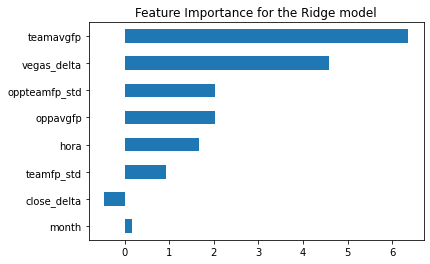

In [38]:
# extracting the features from the ridge model

coefficients = (ridge.named_steps['ridge'].coef_).ravel()
features = X.columns  

pd.Series(coefficients, index = features).sort_values(key = abs).plot.barh()
plt.title('Feature Importance for the Ridge model');


In [39]:
# Fitting a RandomForestRegressor using the 'best parameters' found below. It
# still underperforms the simpler linear models

rf_regressor = make_pipeline(
    SimpleImputer(strategy = 'mean'),
    StandardScaler(),
    RandomForestRegressor(n_estimators = 173, min_samples_split = 5, min_samples_leaf = 1,
                          max_features = 'auto', max_depth = 76.25, bootstrap = True))

rf_regressor.fit(X_train, y_train)

rf_predict = rf_regressor.predict(X_test)
rf_MAE = mean_absolute_error(y_test, rf_predict)


print(f'The r2_score for the RF regressor is {rf_regressor.score(X_test, y_test)}')
print(f'The mean absolute error for the RF regressor is {rf_MAE}')

The r2_score for the RF regressor is 0.10320158603546792
The mean absolute error for the RF regressor is 16.854813055225573


In [ ]:
# optimizing the rf regressor with gridsearch for the sake of practice/reps. isn't
# likely to add value

bootstrap = [True, False]
n_estimators = [n for n in np.linspace(10,500, 10)]
max_depth = [n for n in np.linspace(5,100, 5)]
max_features = ['auto', 'sqrt']
min_samples_split = [2,5,10]
min_samples_leaf = [1,2,5]

rf_grad = {
    'randomforestregressor__bootstrap' : bootstrap,
    'randomforestregressor__n_estimators' : n_estimators,
    'randomforestregressor__max_depth' : max_depth,
    'randomforestregressor__max_features' : max_features,
    'randomforestregressor__min_samples_split' : min_samples_split,
    'randomforestregressor__min_samples_leaf' : min_samples_leaf}


rf_search = RandomizedSearchCV(rf_regressor, n_iter = 10, cv = 3, refit = False,
                               verbose = 2, param_distributions = rf_grad)

rf_search.fit(X_train, y_train)
rf_search.best_params_